In [ ]:
!pip install yfinance

In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import plotly.express as px

**Performance Evaluation**

In [ ]:
from sklearn import metrics

title_name = []
r2_score = []
mae = []
mse = []
acc = []

def evaluate(y_actual, y_predicted, title):
    errors = abs(y_predicted - y_actual)
    mape = 100 * np.mean(errors / y_actual)
    accuracy = 100 - mape
    
    title_name.append(title)
    r2_score.append(metrics.r2_score(y_actual, y_predicted))
    mae.append(metrics.mean_absolute_error(y_actual, y_predicted))
    mse.append(metrics.mean_squared_error(y_actual, y_predicted))
    acc.append(round(accuracy, 2))

**DataSet**

In [ ]:
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.151495,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.546274,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.085485,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.111168,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.228088,283192000
...,...,...,...,...,...,...
2021-09-24,145.660004,147.470001,145.559998,146.919998,146.101318,53477900
2021-09-27,145.470001,145.960007,143.820007,145.369995,144.559952,74150700
2021-09-28,143.250000,144.750000,141.690002,141.910004,141.119232,108972300


Text(0, 0.5, 'Prices ($)')

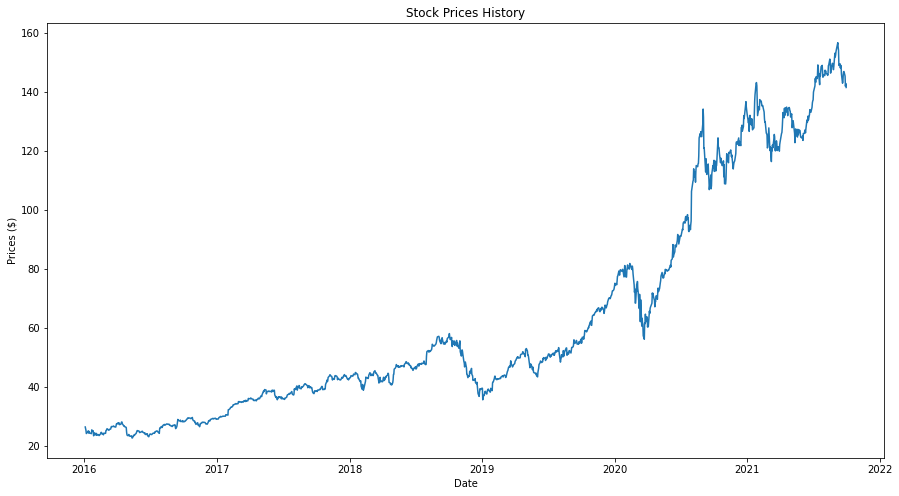

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

In [ ]:
def change_step(x):
  x_train = []
  y_train = []

  for i in range(x, len(train_data)):
      x_train.append(train_data[i-x:i, 0])
      y_train.append(train_data[i, 0])
      
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  test_data = scaled_data[training_data_len-x: , : ]
  x_test = []
  y_test = values[training_data_len:]

  for i in range(x, len(test_data)):
    x_test.append(test_data[i-x:i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return x_train, y_train, x_test, y_test

In [ ]:
def model(x_train):
  model = keras.Sequential()
  model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(layers.LSTM(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

In [ ]:
def predictions(model, x_train, y_train, x_test):
  model.fit(x_train, y_train, batch_size= 1, epochs=3)
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  return predictions

In [ ]:
def prediction_visualization(y_predicted):
  data = stock_data.filter(['Close'])
  train = data[:training_data_len]
  validation = data[training_data_len:]
  validation['Predictions'] = y_predicted
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Close Price USD ($)')
  plt.plot(train)
  plt.plot(validation[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()

In [ ]:
x_train, y_train, x_test, y_test = change_step(60)
model1 = model(x_train)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_predicted = predictions(model1, x_train, y_train, x_test)

Epoch 1/3
1098/1098 [==============================] - 50s 45ms/step - loss: 5.0840e-04
Epoch 2/3
1098/1098 [==============================] - 44s 40ms/step - loss: 2.7760e-04
Epoch 3/3
1098/1098 [==============================] - 45s 41ms/step - loss: 2.1499e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


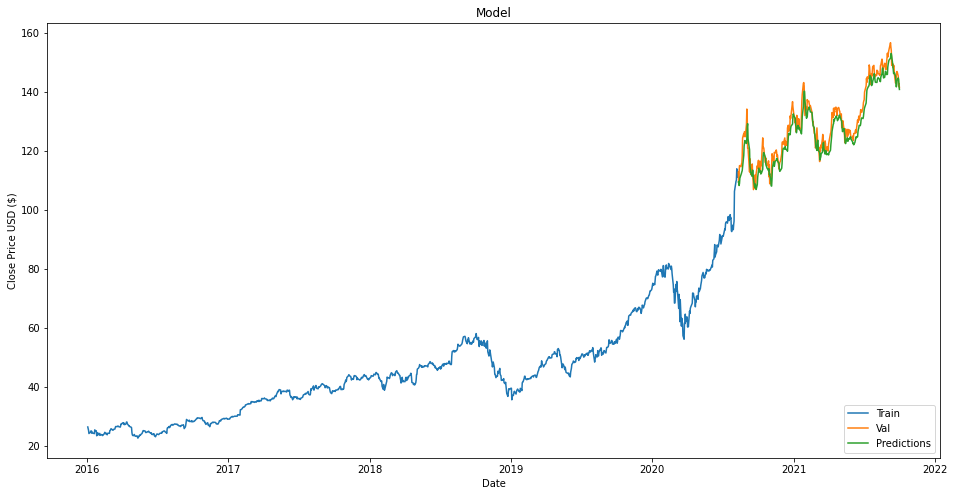

In [ ]:
evaluate(y_test, y_predicted, '60 Steps')
prediction_visualization(y_predicted)

In [ ]:
x_train, y_train, x_test, y_test = change_step(30)
model2 = model(x_train)
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_predicted = predictions(model2, x_train, y_train, x_test)

Epoch 1/3
1098/1098 [==============================] - 50s 43ms/step - loss: 9.8509e-04
Epoch 2/3
1098/1098 [==============================] - 56s 51ms/step - loss: 3.2697e-04
Epoch 3/3
1098/1098 [==============================] - 43s 39ms/step - loss: 2.2164e-04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


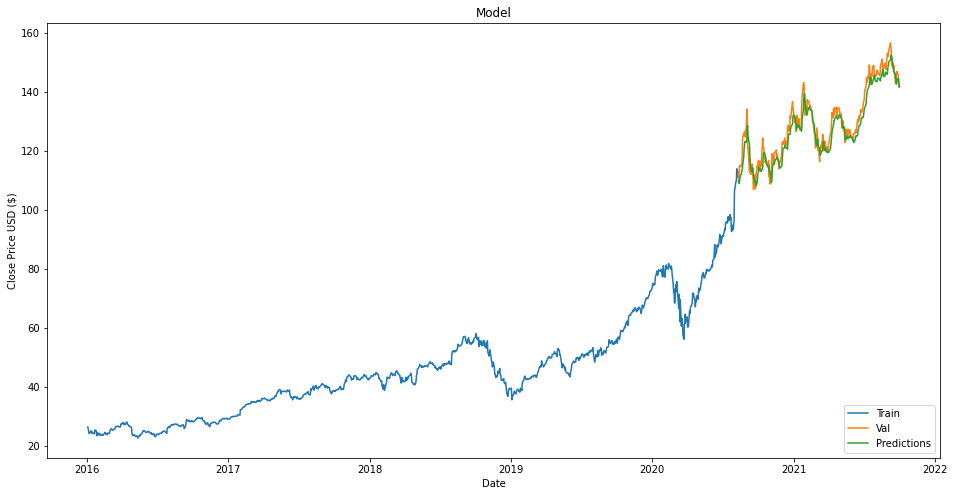

In [ ]:
evaluate(y_test, y_predicted, '30 Steps')
prediction_visualization(y_predicted)

**Performace Comparison**

In [ ]:
di = {'Name': title_name, 'Accuracy': acc, 'F-Score': r2_score, 'MAE': mae, 'MSE': mse}
result_df = pd.DataFrame(di)
print(result_df)

       Name  Accuracy   F-Score       MAE        MSE
0  60 Steps     89.68  0.907554  2.983456  12.866311
1  30 Steps     89.84  0.913573  2.822866  12.028564


In [ ]:
fig = px.bar(result_df, 
             x='Name', 
             y='Accuracy')
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    legend_title='',
    title = "Accuracy of Models"
)
fig.update_xaxes(title_font_family="Times New Roman", title='Models')
fig.update_yaxes(title_font_family="Times New Roman", title='Accuracy')
                  
fig.show()